In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import fits
from cycspec_simulator import (
    TemplateProfile,
    BasebandModel,
    FreqOnlyPredictor,
    PolynomialPredictor,
    ExponentialScatteringModel,
    ObservingMetadata,
    Time,
    pspec_numba,
    guppi_raw,
)

%matplotlib notebook

In [2]:
template_file = "B1937+21.Rcvr1_2.GUPPI.15y.x.sum.sm"
template = TemplateProfile.from_file(template_file)
template.normalize()
template.make_posdef()

Adjusting I**2 by 5.5361972783884994e-08


In [3]:
metadata = ObservingMetadata.from_file(template_file)
metadata.observer = "cycspec-simulator"

In [4]:
chan_bw = 1.5625e6 # Hz
obsfreq = 1.5e9 # Hz
#pulse_freq = 641.948222127829 # Hz
#predictor = FreqOnlyPredictor(pulse_freq, epoch=Time(60000, 0, 0))
predictor = PolynomialPredictor.from_file("polyco-B1937+21-60000.dat")
model = BasebandModel(template, predictor=predictor, chan_bw=chan_bw, nchan=2, obsfreq=obsfreq)

In [5]:
scattering_model = ExponentialScatteringModel(
    scattering_time=40e-6,
    chan_bw=model.chan_bw,
    cutoff=20,
)
pattern = scattering_model.realize()

<IPython.core.display.Javascript object>


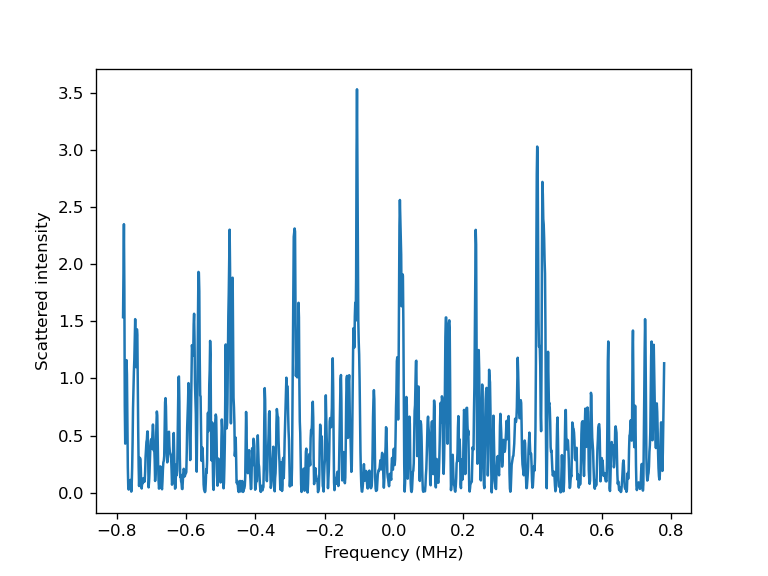

In [6]:
pattern.plot_scattered_intensity()

In [7]:
t_start = Time(60000, 1800, -(pattern.n_samples-1)/chan_bw)
data = model.sample(2**22 + pattern.n_samples - 1, t_start=t_start)
data = pattern.scatter(data)

In [8]:
%time pspec = pspec_numba(data, 1024, 1024, predictor)

CPU times: user 3min 14s, sys: 506 ms, total: 3min 15s
Wall time: 3min 14s


<IPython.core.display.Javascript object>


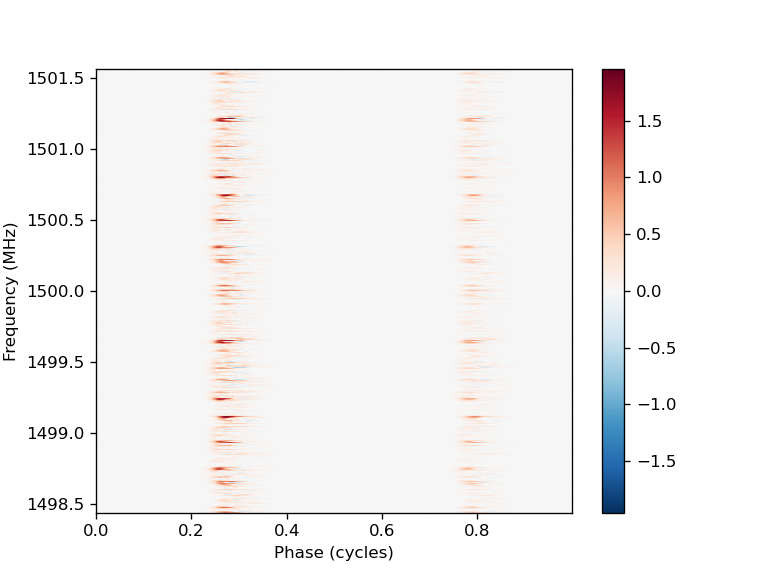

In [9]:
pc = pspec.plot(shift=0.25, cmap='RdBu_r', sym_lim=True)
plt.colorbar(pc)
plt.show()

In [10]:
data.nchan

2

<IPython.core.display.Javascript object>


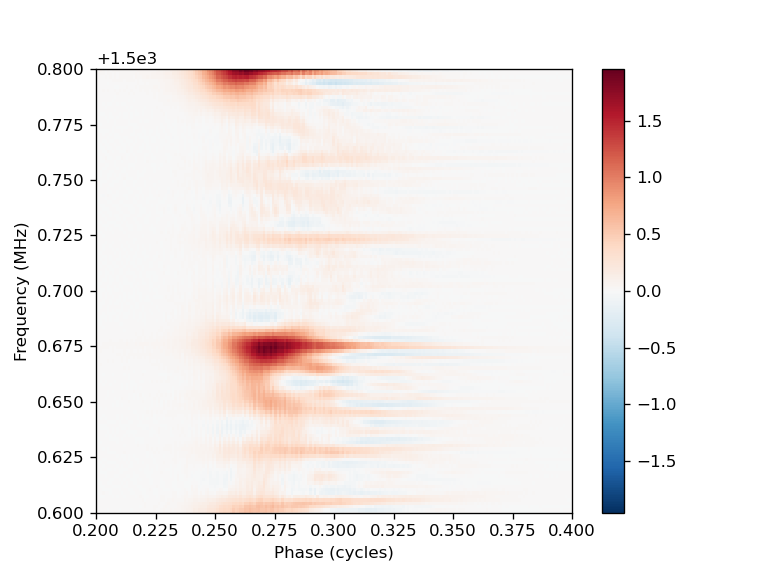

In [11]:
pc = pspec.plot(what='I', shift=0.25, cmap='RdBu_r', sym_lim=True)
plt.colorbar(pc)
plt.xlim([0.2, 0.4])
plt.ylim([1500.6, 1500.8])
plt.show()

<IPython.core.display.Javascript object>


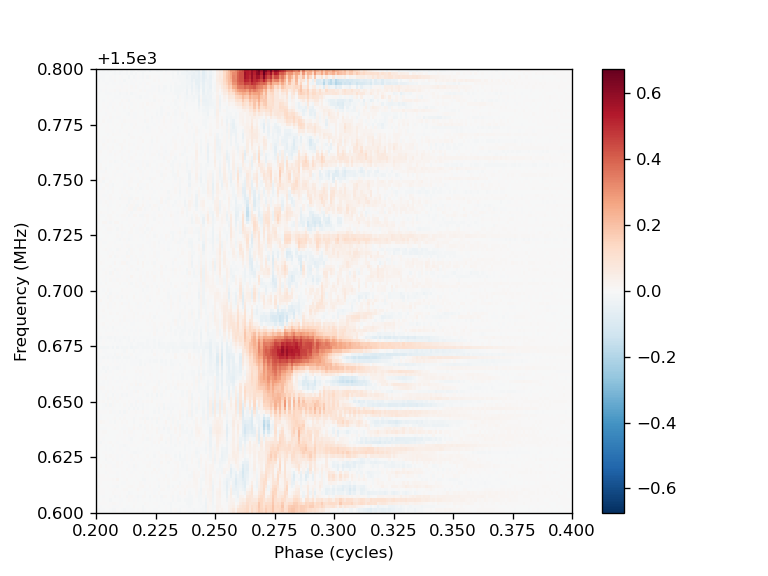

In [12]:
pc = pspec.plot(what='U', shift=0.25, cmap='RdBu_r', sym_lim=True)
plt.colorbar(pc)
plt.xlim([0.2, 0.4])
plt.ylim([1500.6, 1500.8])
plt.show()

In [13]:
from cycspec_simulator import guppi_raw

In [36]:
%run ~/python/cycspec-simulator/cycspec_simulator/guppi_raw.py

In [38]:
write('B1937+21-2channel-no-overlap.raw', data, overlap=0, metadata=metadata)

In [37]:
write('B1937+21-2channel-with-overlap.raw', data, overlap=12288, metadata=metadata)

In [25]:
2**20//8192

128

In [30]:
!head B1937+21-2channel-new.raw

SRC_NAME= 'B1937+21'                                                            TELESCOP= 'GBT     '                                                            FRONTEND= 'Rcvr1_2 '                                                            BACKEND = 'GUPPI   '                                                            RA_STR  = '19:39:38.5920'                                                       DEC_STR = '21:34:59.5200'                                                       OBSERVER= 'cycspec-simulator'                                                   OBSFREQ = '1500    '                                                            OBSBW   = '3.125   '                                                            TBIN    = '6.4e-07 '                                                            STT_IMJD=                60000                                                  STT_SMJD=                 1800                                                  STT_OFFS=                  0.0          

In [18]:
headers, new_data = guppi_raw.read('B1937+21-40us.raw', use_dask=False)

In [20]:
np.all(new_data == guppi_raw.quantize(data))

True

In [42]:
qd = guppi_raw.quantize(data)
cqd = qd[..., 0] + 1j*qd[..., 1]

In [82]:
from blimpy import GuppiRaw
gr = GuppiRaw('B1937+21-40us.raw')
blimpy_header0, blimpy_data0 = gr.read_next_data_block()
blimpy_data0 = blimpy_data0.copy()
blimpy_header1, blimpy_data1 = gr.read_next_data_block()
blimpy_data1 = blimpy_data1.copy()
blimpy_header2, blimpy_data2 = gr.read_next_data_block()
blimpy_data2 = blimpy_data2.copy()
blimpy_header3, blimpy_data3 = gr.read_next_data_block()
blimpy_data3 = blimpy_data3.copy()

In [83]:
blimpy_data = np.concatenate([blimpy_data0, blimpy_data1, blimpy_data2, blimpy_data3], axis=1)

In [84]:
np.all(blimpy_data == cqd)

True